<a href="https://colab.research.google.com/github/hegone/urban-pollution-trends-ml/blob/main/ARIMA_PM10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pmdarima

<ipython-input-3-762c96bb11fa>:16: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  data_2020_onwards = data['pm10']['2020-01-01':].resample('M').mean()


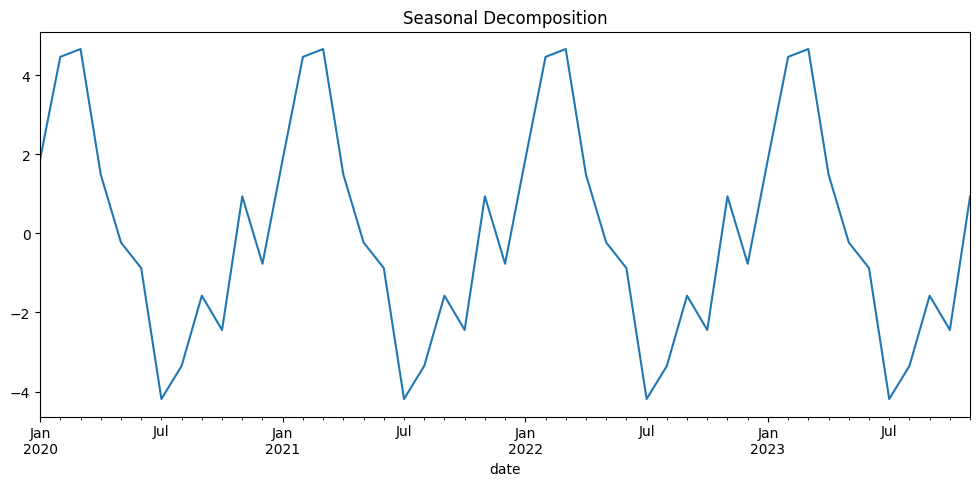

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=282.014, Time=3.69 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=274.503, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=276.917, Time=0.33 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=277.025, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=421.293, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=275.084, Time=0.31 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=275.218, Time=0.17 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=276.910, Time=0.92 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=275.273, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=275.489, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=276.986, Time=0.27 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 6.330 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   47
Model:                        SARIMAX   Log Likelihood                -135.251
Date:                Thu, 18 Apr 2024   AIC                            274.503
Time:                        19:58:51   BIC                            278.203
Sample:                    01-31-2020   HQIC                           275.895
                         - 11-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     20.4928      0.695     29.499      0.000      19.131      21.854
sigma2        18.4949      3.149      5.873      0.000      12.323      24.667
===================================================================================
Ljung-Box (L1) (Q):                   1.23   Jarque-Bera (JB):                10.22
Prob(Q):                              0.27   Prob(JB):                         0.01
Heteroskedasticity (H):               1.21   Skew:                             0.82
Prob(H) (two-sided):                  0.70   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Load and preprocess the data
file_path = '/content/drive/MyDrive/Air Quality Forecast/London/Cleaned_London_Air_Quality.csv'
data = pd.read_csv(file_path)
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data_2020_onwards = data['pm10']['2020-01-01':].resample('M').mean()

# Check for seasonality
seasonal_decompose_result = seasonal_decompose(data_2020_onwards, model='additive')
seasonal_decompose_result.seasonal.plot(title="Seasonal Decomposition", figsize=(12, 5))
plt.show()

# Perform grid search to find the best SARIMA parameters
# The seasonal period s is typically known from domain knowledge, e.g., s = 12 for monthly data with yearly seasonality
s = 12

# Using auto_arima to find the best SARIMA parameters
sarima_model = auto_arima(data_2020_onwards, seasonal=True, m=s, trace=True,
                          error_action='ignore', suppress_warnings=True)

# Best model summary
sarima_model.summary()


<ipython-input-4-783357882821>:14: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  data_2020_onwards = data['pm10']['2020-01-01':].resample('M').mean()
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


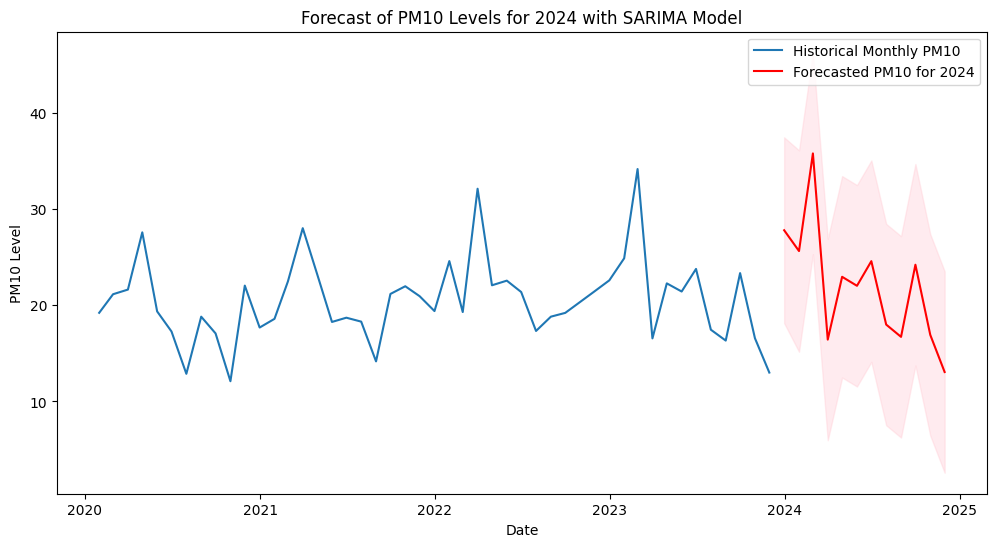

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/drive/MyDrive/Air Quality Forecast/London/Cleaned_London_Air_Quality.csv'
data = pd.read_csv(file_path)

# Convert 'date' to datetime and set as index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Filter data from 2020 onwards and resample to monthly frequency
data_2020_onwards = data['pm10']['2020-01-01':].resample('M').mean()

# Fit the SARIMA model (with previously determined parameters)
sarima_model = SARIMAX(data_2020_onwards,
                       order=(0, 0, 1),
                       seasonal_order=(1, 0, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()

# Forecast for the next 12 months (2024)
forecast = sarima_result.get_forecast(steps=12)
forecast_index = pd.date_range(start=data_2020_onwards.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the historical data and the forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(data_2020_onwards, label='Historical Monthly PM10')
plt.plot(forecast_index, forecast_mean, color='red', label='Forecasted PM10 for 2024')
plt.fill_between(forecast_index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('Forecast of PM10 Levels for 2024 with SARIMA Model')
plt.xlabel('Date')
plt.ylabel('PM10 Level')
plt.legend()
plt.show()

# Output the forecasted values and confidence intervals
forecast_output = pd.DataFrame({'Forecast': forecast_mean,
                                'Lower CI': forecast_conf_int.iloc[:, 0],
                                'Upper CI': forecast_conf_int.iloc[:, 1]},
                               index=forecast_index)

# Save forecast data to a CSV file
forecast_output.to_csv('/content/drive/MyDrive/Air Quality Forecast/London/PM10_Forecast_2024.csv')

# The path to the saved forecast CSV file
forecast_output_path = '/content/drive/MyDrive/Air Quality Forecast/London/PM10_Forecast_2024.csv'
